# Heart Disease Risk Assessment using Bayesian Networks

### Authors: Matteo Fasulo, Luca Tedeschini, Antonio Gravina, Luca babboni

### Course: Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

### Overview

**Cardiovascular diseases** (CVDs) are the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 32% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [[1]](#1). 

The main risk factors for **heart disease** are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects may include raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity [[1]](#1). Since the 1930s, research has identified diverse **CVD risk factors** [[2]](#2). Notably, the World Health Organization categorizes factors as modifiable (influenced by lifestyle) and non-modifiable [[3]](#3). Interestingly, modifiable factors can be significantly impacted by individual choices and interventions. 

In this notebook, we will use a **Bayesian Network** to assess the **risk of heart disease** in a patient based on these risk factors. We will face the modelling of **causal relations** between the risk factors and the disease, and we will use the network to make **predictions** about the risk of heart disease in a patient. The aim is to learn a model which **given** the risk factors of a patient as input (**evidence**), can predict the probability of the patient having heart disease. The causal relations between the risk factors and the disease will be both learned from data and from **domain knowledge** found in the **literature** and in **medical guidelines**.

The work was inspired by a paper [[4]](#4) in which the authors used a Bayesian Network to assess the risk of heart disease in a patient. Their work guided us in the choice of the risk factors and in the structure of the network. However, we will use a different dataset and we will use a different approach to learn the parameters of the network.

# Libraries

In [302]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# Preprocessing

The original dataset 

In [303]:
df = pd.read_csv(f'data{os.sep}heart.csv')

df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

df['ExerciseAngina'] = df['ExerciseAngina'].apply(
    lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(
    lambda x: False if x == 0 else True)

df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)
df["Age"] = pd.qcut(x=df["Age"], q=2, labels=["young", "old"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, 1000], labels=[
                         "normal", "high", "very high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[
                           0, 200, 240, 1000], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.cut(x=df["MaxHR"], bins=3)
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=3, labels=[
                       "low", "medium", "high"])

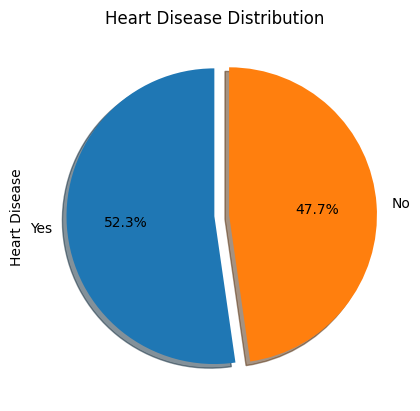

In [304]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[0, 0.1], shadow=True, labels=["Yes", "No"], label="Heart Disease", title="Heart Disease Distribution")
plt.show()

In [305]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Bayesian Network from Hill Climbing unconstrained

In [306]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore')

  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True i

In [307]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(nx_graph, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

NameError: name 'nx_graph' is not defined

Ok, good but we want to express some edges and remove other with no causal meaning. We proceed to remove:
- HeartDisease -> Cholesterol
- Oldpeak -> HeartDisease
- ST_Slope -> HeartDisease
- ST_Slope -> MaxHR
- Nothing affects Age
- Nothing affects Sex

# Constrained

In [308]:
black_list = [(target_variable, 'Cholesterol'),
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [309]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True i

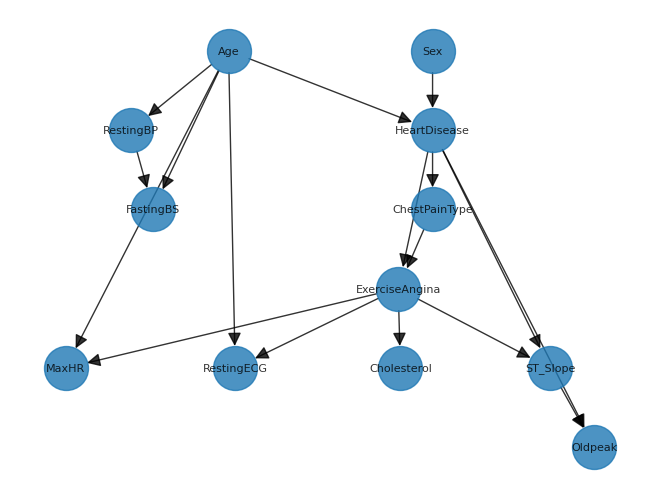

In [310]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [311]:
estimated_model.remove_edge('ExerciseAngina', 'Cholesterol')
estimated_model.add_edge('Sex', 'Cholesterol')
estimated_model.add_edge('Cholesterol', target_variable)
# estimated_model.add_edge('Age', 'Cholesterol')

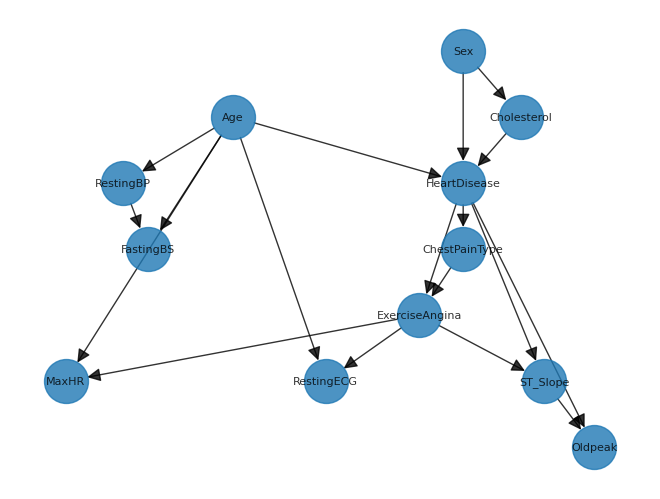

In [312]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [313]:
model = BayesianNetwork(estimated_model.edges())

In [314]:
model.get_cardinality()

defaultdict(int, {})

In [ ]:
if not os.path.isdir('model'):
    os.mkdir('model')
model.save(f'model{os.sep}heart_disease_model.bif')

KeyError: 'Age'

In [315]:
model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
model.get_cpds()
assert model.check_model()

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True i

In [316]:
y_pred = model.predict(X_test)
y_pred.head()

  0%|          | 0/141 [00:00<?, ?it/s]

,HeartDisease
0,False
1,False
2,False
3,False
4,True


In [317]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.8974358974358975

In [318]:
accuracy_score(y_test, y_pred[target_variable])

0.9133333333333333

# Average FBeta

Visto che l'f beta è molto dipendente dallo shuffle, fare una media con un kfold restituisce un f beta più realistico

In [319]:
from sklearn.model_selection import KFold

In [383]:
kfold = KFold(10, shuffle=True)
train_kfold = pd.concat([X_train, y_train], axis=1)

In [ ]:
score = []
for train, test in kfold.split(train_kfold):
    model.fit(train_kfold.iloc[train, :], estimator=BayesianEstimator, prior_type="BDeu")
    y_pred = model.predict(train_kfold.iloc[test, :-1])
    score.append(fbeta_score(train_kfold.iloc[test, -1], y_pred[target_variable], beta=2))

In [385]:
sum(score) / len(score)

0.8366657828443183

### References

<a id="1">[1]</a>
World Health Organization. (2024). Cardiovascular diseases (CVDs). <https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)>

<a id="2">[2]</a>
Mahmood, S. S., Levy, D., Vasan, R. S., & Wang, T. J. (2014). The Framingham Heart Study and the epidemiology of cardiovascular disease: a historical perspective. Lancet (London, England), 383(9921), 999–1008. <https://doi.org/10.1016/S0140-6736(13)61752-3>

<a id="3">[3]</a>
WHO CVD Risk Chart Working Group (2019). World Health Organization cardiovascular disease risk charts: revised models to estimate risk in 21 global regions. The Lancet. Global health, 7(10), e1332–e1345. <https://doi.org/10.1016/S2214-109X(19)30318-3>

<a id="4">[4]</a>
Ordovas, J.; Rios-Insua, D.; Santos-Lozano, A.; Lucia, A.; Torres, A.; Kosgodagan, A.; and Camacho, J. (2023). A bayesian network model for predicting cardiovascular risk. Computer Methods and Programs in Biomedicine. <https://doi.org/10.1016/j.cmpb.2023.107405>